# Run experiments

In this notebook we run the experiments that are shown in Tables 2, 3, 4, and 5.

In [1]:
%matplotlib inline
import sys
import os
import time

import pandas as pd
import numpy as np

import CBECSLib
CBECSLib = reload(CBECSLib)

import itertools
from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

#sklearn base
import sklearn.base

#sklearn utility
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

#sklearn models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import Lasso, ElasticNet, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

#IPython utilities
from IPython.display import HTML,display
def show(html):
    display(HTML(html))

In [2]:
RESULTS_DIR = "results/" # where output is written to
DATASET = 1 # for the extended set of features use 0, for the common set of features use 1

In [3]:
pbaLabels = CBECSLib.pbaLabels
pbaPlusLabels = CBECSLib.pbaPlusLabels

getDataset = CBECSLib.getDataset
getClassFrequencies = CBECSLib.getClassFrequencies
getDataSubset = CBECSLib.getDataSubset

## Create Regression Models

In [4]:
regressors = [
    LinearRegression(n_jobs=-1),
    Ridge(),
    SVR(),
    Lasso(),
    ElasticNet(),
    LinearSVR(verbose=0),
    AdaBoostRegressor(),
    BaggingRegressor(n_jobs=-1),
    GradientBoostingRegressor(verbose=0),
    RandomForestRegressor(n_jobs=-1, verbose=0),
    ExtraTreesRegressor(n_jobs=-1, verbose=0),
    MLPRegressor(),
    KNeighborsRegressor()    
]
regressorNames = [
    "Linear Regression",
    "Ridge Regressor",
    "SVR",
    "Lasso",
    "ElasticNet",
    "Linear SVR",
    "AdaBoost",
    "Bagging",
    "XGBoost",
    "Random Forest Regressor",
    "Extra Trees Regressor",
    "MLP Regressor",
    "KNN Regressor"
]
assert len(regressors) == len(regressorNames)
numRegressors = len(regressors)

metrics = [
    mean_absolute_error,
    lambda y_true, y_pred: 10.0 ** mean_absolute_error(y_true, y_pred),
    median_absolute_error,
    lambda y_true, y_pred: 10.0 ** median_absolute_error(y_true, y_pred),
    r2_score,
    lambda y_true, y_pred: r2_score(10.0 ** y_true, 10.0 ** y_pred)
]
metricNames = [
    "Mean Absolute Error",
    "10^Mean AE",
    "Median Absolute Error",
    "10^Median AE",
    "$r^2$",
    "$r^2$ linspace"
]
assert len(metrics) == len(metricNames)
numMetrics = len(metrics)

# Experiments Training on All Data, Testing Per PBA

In [8]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

numSplits = 10
numRepeats = 10
outputFn = "test_perPBA_%d" % (DATASET)

results = np.zeros((numRepeats, numSplits, numRegressors, numClassVals, numMetrics), dtype=float)

for i in range(numRepeats):
    print "Repetition %d" % (i)

    kf = StratifiedKFold(n_splits=numSplits)
    for j, (train, test) in enumerate(kf.split(X,classVals)):
        #print "\tSplit %d" % (j)
        X_train, X_test = X[train,:], X[test,:]
        Y_train, Y_test = Y[train], Y[test]
        classVals_train, classVals_test = classVals[train].copy(), classVals[test].copy()

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        for k in range(numRegressors):
            regressor = sklearn.base.clone(regressors[k])
            regressorName = regressorNames[k]

            #train model
            regressor.fit(X_train,Y_train)

            for l,classVal in enumerate(classOrdering):

                className = pbaLabels[classVal]
                numberOfSamples = classFrequencies[classVal]

                X_temp, Y_temp = getDataSubset(X_test,Y_test,classVals_test,classVal)

                #predict model
                predicted = regressor.predict(X_temp)
                predicted[predicted<0] = 0

                #evaluate model
                for m,metric in enumerate(metrics):
                    metricName = metricNames[m]
                    score = metric(Y_temp,predicted)
                    results[i,j,k,l,m] = score
        
results = np.array(results)

metricIndex = 4
results = results.reshape(-1, numRegressors, numClassVals, numMetrics)

classNames = [pbaLabels[pbaLabel] for pbaLabel in classOrdering]

meanResults = results.mean(axis=0)
meanResultTable = pd.DataFrame(meanResults[:,:,metricIndex], index=regressorNames, columns=classNames)
meanResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_means.csv" % (outputFn)))

stdResults = results.std(axis=0)
stdResultTable = pd.DataFrame(stdResults[:,:,metricIndex], index=regressorNames, columns=classNames)
stdResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_stds.csv" % (outputFn)))

formattedResults = []
for i in range(numRegressors):
    row = []
    for j in range(numClassVals):
        row.append("%0.2f +/- %0.2f" % (meanResults[i,j,metricIndex], stdResults[i,j,metricIndex]))
    formattedResults.append(row)
formattedResults = np.array(formattedResults)
formattedResultsTable = pd.DataFrame(formattedResults.T, index=classNames, columns=regressorNames)
formattedResultsTable.to_csv(os.path.join(RESULTS_DIR, "%s_formatted.csv" % (outputFn)))

display(formattedResultsTable)

20 classes
Repetition 0
Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5
Repetition 6
Repetition 7
Repetition 8
Repetition 9


,Linear Regression,Ridge Regressor,SVR,Lasso,ElasticNet,Linear SVR,AdaBoost,Bagging,XGBoost,Random Forest Regressor,Extra Trees Regressor,MLP Regressor,KNN Regressor
Office,0.90 +/- 0.01,0.90 +/- 0.01,0.89 +/- 0.01,-0.00 +/- 0.00,0.49 +/- 0.02,0.89 +/- 0.01,0.88 +/- 0.02,0.90 +/- 0.02,0.91 +/- 0.01,0.90 +/- 0.02,0.90 +/- 0.02,0.66 +/- 0.07,0.79 +/- 0.02
Education,0.84 +/- 0.03,0.84 +/- 0.03,0.84 +/- 0.03,-0.17 +/- 0.11,0.37 +/- 0.05,0.82 +/- 0.04,0.81 +/- 0.04,0.85 +/- 0.03,0.87 +/- 0.02,0.85 +/- 0.03,0.85 +/- 0.03,0.34 +/- 0.16,0.60 +/- 0.08
Nonrefrigerated warehouse,0.81 +/- 0.03,0.81 +/- 0.03,0.80 +/- 0.04,-0.18 +/- 0.07,0.20 +/- 0.09,0.80 +/- 0.04,0.75 +/- 0.07,0.77 +/- 0.06,0.81 +/- 0.04,0.77 +/- 0.06,0.77 +/- 0.06,0.59 +/- 0.10,0.56 +/- 0.11
Service,0.65 +/- 0.11,0.65 +/- 0.11,0.63 +/- 0.10,-1.17 +/- 0.53,-0.37 +/- 0.31,0.62 +/- 0.10,0.54 +/- 0.17,0.60 +/- 0.12,0.66 +/- 0.10,0.61 +/- 0.12,0.59 +/- 0.11,0.14 +/- 0.27,0.41 +/- 0.13
Religious worship,0.77 +/- 0.07,0.77 +/- 0.07,0.77 +/- 0.07,-1.01 +/- 0.71,-0.29 +/- 0.39,0.75 +/- 0.08,0.71 +/- 0.11,0.72 +/- 0.09,0.77 +/- 0.09,0.72 +/- 0.08,0.73 +/- 0.09,0.34 +/- 0.35,0.52 +/- 0.09
Retail other than mall,0.86 +/- 0.05,0.86 +/- 0.05,0.82 +/- 0.07,-0.27 +/- 0.23,0.26 +/- 0.16,0.85 +/- 0.06,0.77 +/- 0.07,0.81 +/- 0.08,0.86 +/- 0.06,0.81 +/- 0.08,0.82 +/- 0.08,0.45 +/- 0.19,0.58 +/- 0.12
Public assembly,0.89 +/- 0.03,0.89 +/- 0.03,0.85 +/- 0.06,-0.02 +/- 0.02,0.38 +/- 0.04,0.88 +/- 0.03,0.82 +/- 0.03,0.86 +/- 0.03,0.89 +/- 0.02,0.86 +/- 0.04,0.86 +/- 0.03,0.60 +/- 0.15,0.72 +/- 0.09
Food service,0.66 +/- 0.07,0.66 +/- 0.07,0.59 +/- 0.12,-0.07 +/- 0.06,0.11 +/- 0.07,0.62 +/- 0.07,-0.14 +/- 0.50,0.56 +/- 0.15,0.70 +/- 0.09,0.56 +/- 0.13,0.60 +/- 0.11,-0.35 +/- 0.58,0.28 +/- 0.20
Strip shopping mall,0.85 +/- 0.06,0.85 +/- 0.06,0.85 +/- 0.05,-1.06 +/- 0.46,-0.28 +/- 0.24,0.83 +/- 0.06,0.60 +/- 0.09,0.87 +/- 0.04,0.91 +/- 0.03,0.87 +/- 0.05,0.88 +/- 0.05,0.21 +/- 0.27,0.60 +/- 0.07
Lodging,0.85 +/- 0.07,0.85 +/- 0.07,0.83 +/- 0.09,-0.68 +/- 0.48,-0.05 +/- 0.28,0.83 +/- 0.07,0.71 +/- 0.10,0.83 +/- 0.11,0.87 +/- 0.07,0.82 +/- 0.11,0.81 +/- 0.12,0.24 +/- 0.27,0.58 +/- 0.18


# Experiments Training on All Data, Testing on All Data

In [5]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

numSplits = 10
numRepeats = 10
outputFn = "test_all_%d" % (DATASET)

results = np.zeros((numRepeats, numSplits, numRegressors, numMetrics), dtype=float)

for i in range(numRepeats):
    print "Repetition %d" % (i)

    kf = StratifiedKFold(n_splits=numSplits)
    for j, (train, test) in enumerate(kf.split(X,classVals)):
        #print "\tSplit %d" % (j)
        X_train, X_test = X[train,:], X[test,:]
        Y_train, Y_test = Y[train], Y[test]
        classVals_train, classVals_test = classVals[train].copy(), classVals[test].copy()

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        for k in range(numRegressors):
            regressor = sklearn.base.clone(regressors[k])
            regressorName = regressorNames[k]

            #train model
            regressor.fit(X_train,Y_train)

            #predict model
            predicted = regressor.predict(X_test)
            predicted[predicted<0] = 0

            #evaluate model
            for m,metric in enumerate(metrics):
                metricName = metricNames[m]
                score = metric(Y_test,predicted)
                results[i,j,k,m] = score
        
results = np.array(results)

results = results.reshape(-1, numRegressors, numMetrics)

classNames = [pbaLabels[pbaLabel] for pbaLabel in classOrdering]

meanResults = results.mean(axis=0)
meanResultTable = pd.DataFrame(meanResults, index=regressorNames, columns=metricNames)
meanResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_means.csv" % (outputFn)))

stdResults = results.std(axis=0)
stdResultTable = pd.DataFrame(stdResults, index=regressorNames, columns=metricNames)
stdResultTable.to_csv(os.path.join(RESULTS_DIR, "%s_stds.csv" % (outputFn)))

formattedResults = []
for i in range(numRegressors):
    row = []
    for j in range(numMetrics):
        row.append("%0.2f +/- %0.2f" % (meanResults[i,j], stdResults[i,j]))
    formattedResults.append(row)
formattedResults = np.array(formattedResults)
formattedResultsTable = pd.DataFrame(formattedResults, index=regressorNames, columns=metricNames)
formattedResultsTable.to_csv(os.path.join(RESULTS_DIR, "%s_formatted.csv" % (outputFn)))

display(formattedResultsTable)

20 classes
Repetition 0
Repetition 1
Repetition 2
Repetition 3
Repetition 4
Repetition 5
Repetition 6
Repetition 7
Repetition 8
Repetition 9


,Mean Absolute Error,10^Mean AE,Median Absolute Error,10^Median AE,$r^2$,$r^2$ linspace
Linear Regression,0.52 +/- 0.02,3.33 +/- 0.13,0.43 +/- 0.02,2.72 +/- 0.12,0.53 +/- 0.03,-777.24 +/- 1618.98
Ridge Regressor,0.52 +/- 0.02,3.33 +/- 0.13,0.43 +/- 0.02,2.72 +/- 0.12,0.53 +/- 0.03,-795.12 +/- 1675.29
SVR,0.39 +/- 0.01,2.44 +/- 0.07,0.29 +/- 0.01,1.95 +/- 0.04,0.70 +/- 0.03,0.63 +/- 0.17
Lasso,0.79 +/- 0.02,6.17 +/- 0.35,0.69 +/- 0.03,4.92 +/- 0.38,-0.00 +/- 0.00,-0.06 +/- 0.02
ElasticNet,0.76 +/- 0.02,5.75 +/- 0.32,0.67 +/- 0.03,4.67 +/- 0.35,0.09 +/- 0.01,-0.05 +/- 0.02
Linear SVR,0.51 +/- 0.02,3.28 +/- 0.15,0.40 +/- 0.02,2.54 +/- 0.11,0.52 +/- 0.04,-26833.21 +/- 70556.04
AdaBoost,0.43 +/- 0.03,2.71 +/- 0.16,0.36 +/- 0.03,2.29 +/- 0.17,0.68 +/- 0.03,0.31 +/- 0.12
Bagging,0.33 +/- 0.01,2.13 +/- 0.07,0.24 +/- 0.01,1.73 +/- 0.05,0.78 +/- 0.03,0.68 +/- 0.14
XGBoost,0.30 +/- 0.01,1.99 +/- 0.06,0.22 +/- 0.01,1.66 +/- 0.03,0.82 +/- 0.02,0.72 +/- 0.15
Random Forest Regressor,0.33 +/- 0.02,2.13 +/- 0.07,0.24 +/- 0.01,1.73 +/- 0.05,0.78 +/- 0.02,0.67 +/- 0.19


## Visualize Regressor Errors

20 classes
Linear Regression
Training model 1/13	Linear Regression


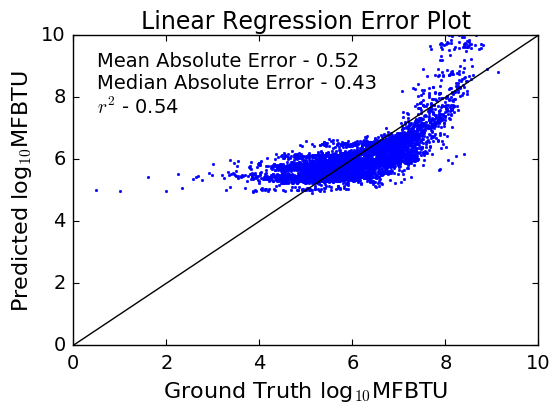

Min error: 0.000019
Max error: 4.520428


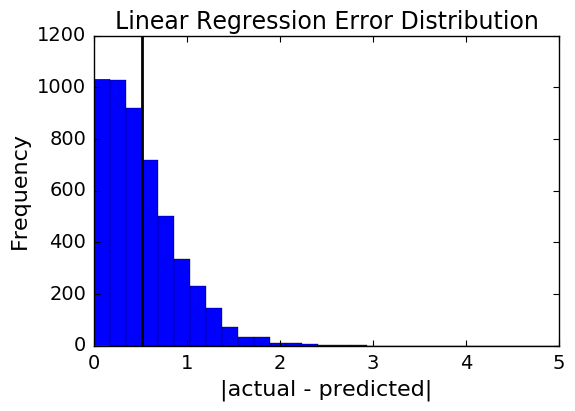

Ridge Regressor
Training model 2/13	Ridge Regressor


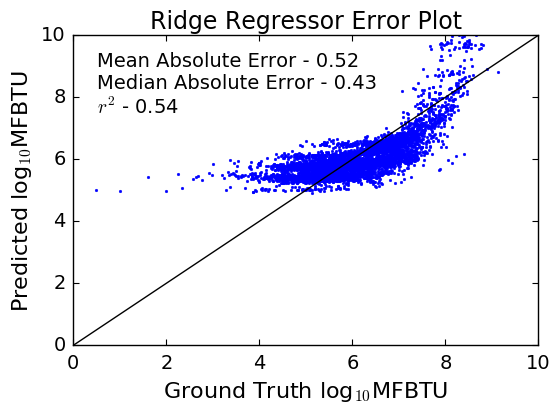

Min error: 0.000233
Max error: 4.520153


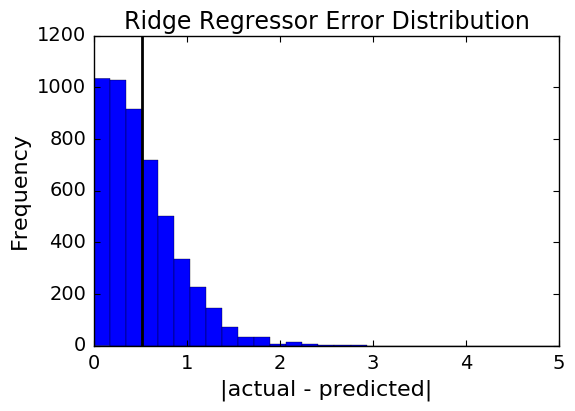

SVR
Training model 3/13	SVR


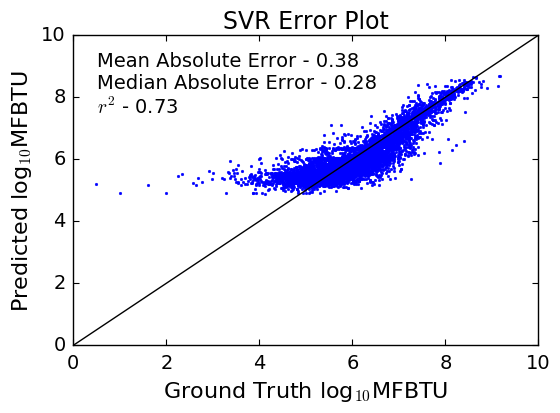

Min error: 0.000082
Max error: 4.715001


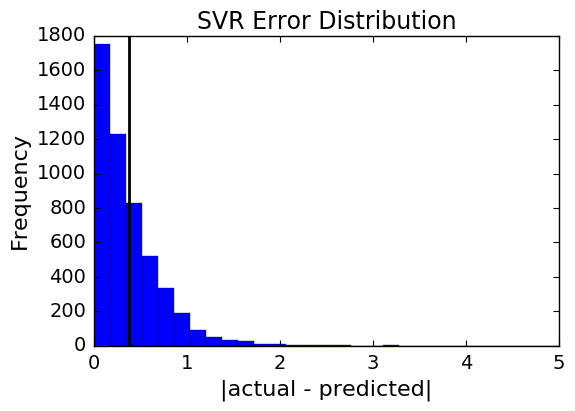

Lasso
Training model 4/13	Lasso


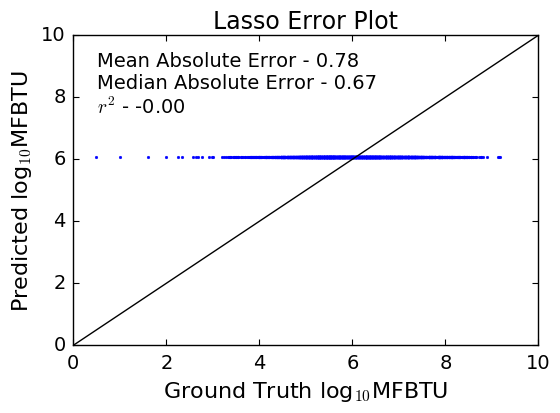

Min error: 0.000143
Max error: 5.581362


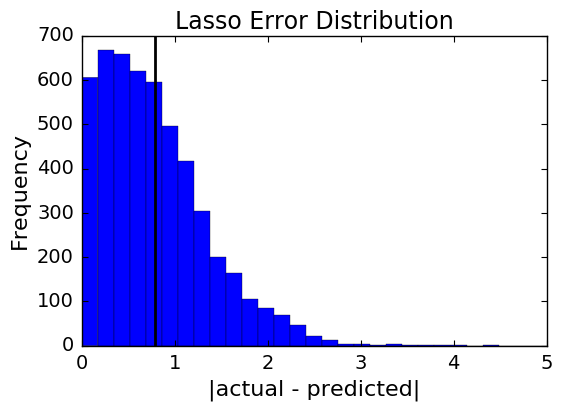

ElasticNet
Training model 5/13	ElasticNet


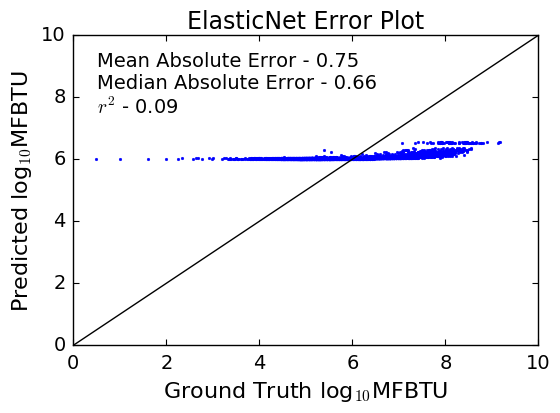

Min error: 0.000111
Max error: 5.547506


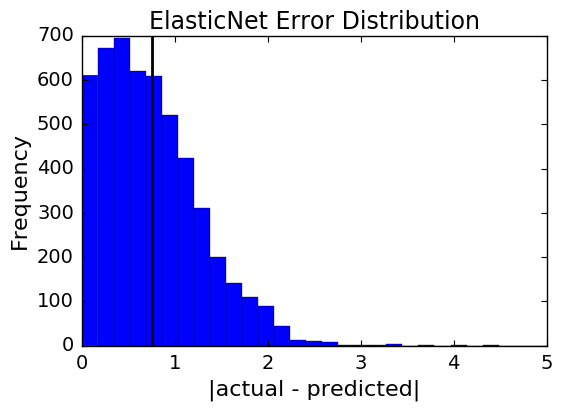

Linear SVR
Training model 6/13	Linear SVR


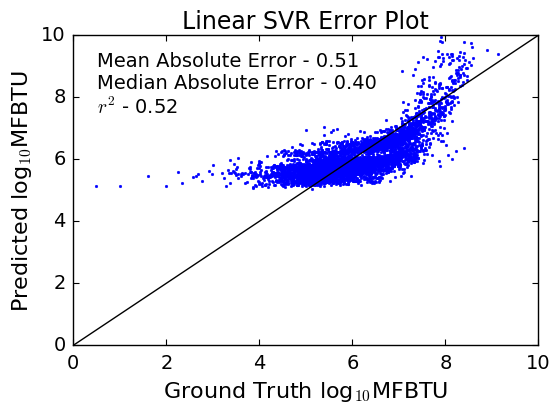

Min error: 0.000000
Max error: 4.667805


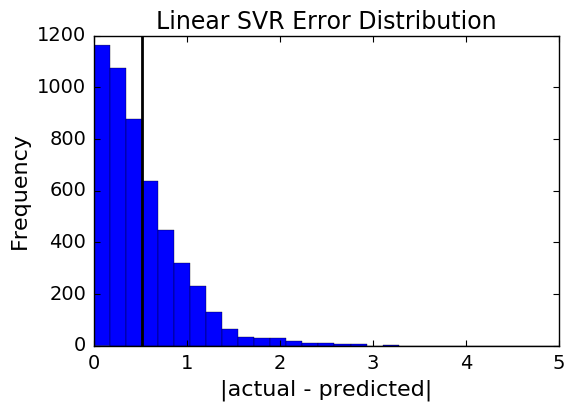

AdaBoost
Training model 7/13	AdaBoost


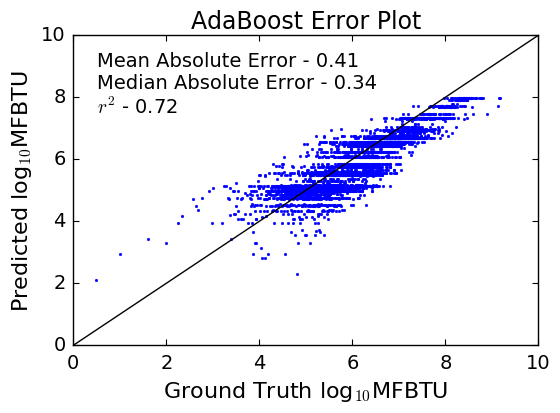

Min error: 0.000009
Max error: 2.500394


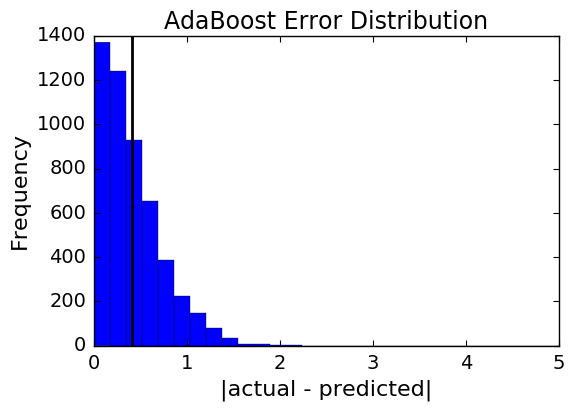

Bagging
Training model 8/13	Bagging


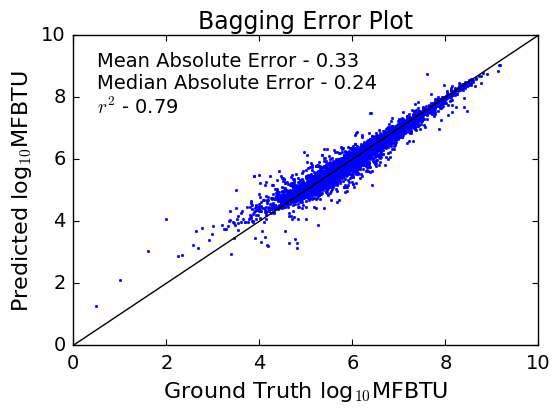

Min error: 0.000000
Max error: 2.091518


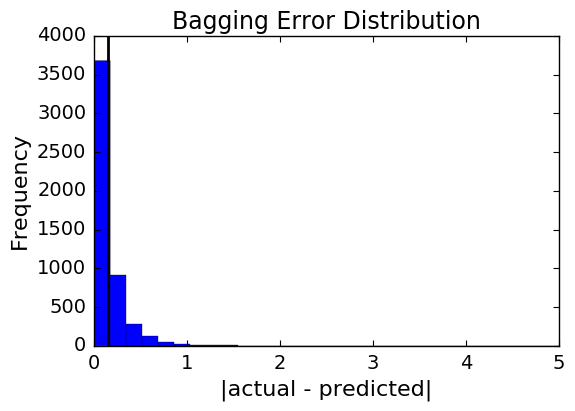

XGBoost
Training model 9/13	XGBoost


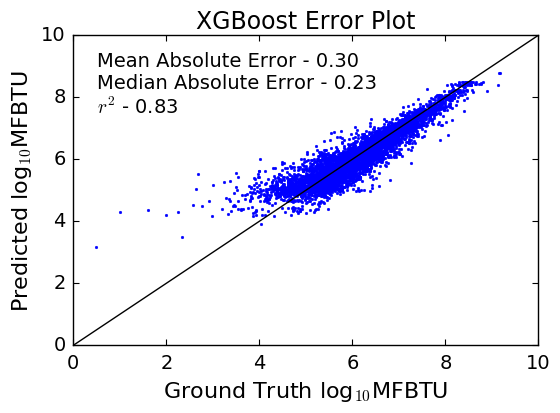

Min error: 0.000071
Max error: 3.307855


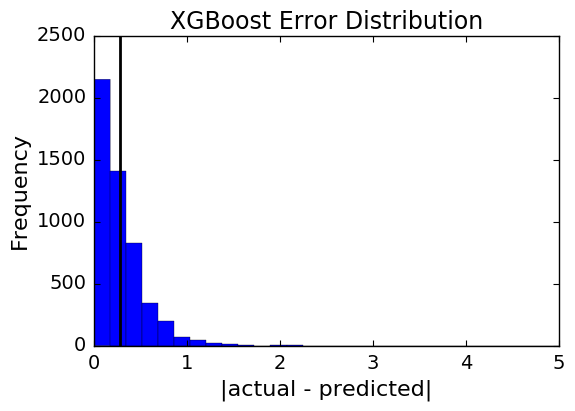

Random Forest Regressor
Training model 10/13	Random Forest Regressor


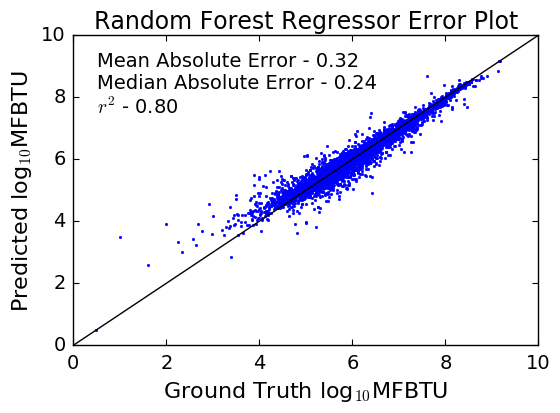

Min error: 0.000000
Max error: 2.492790


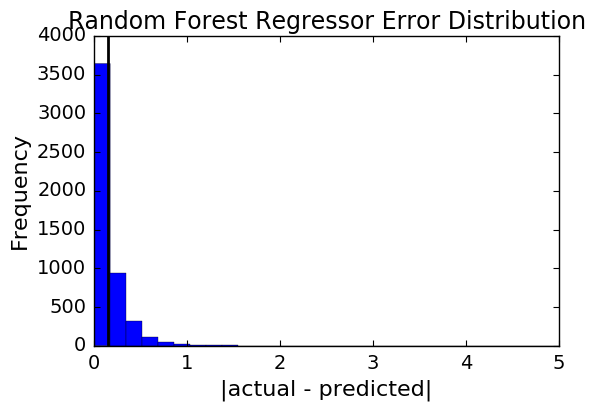

Extra Trees Regressor
Training model 11/13	Extra Trees Regressor


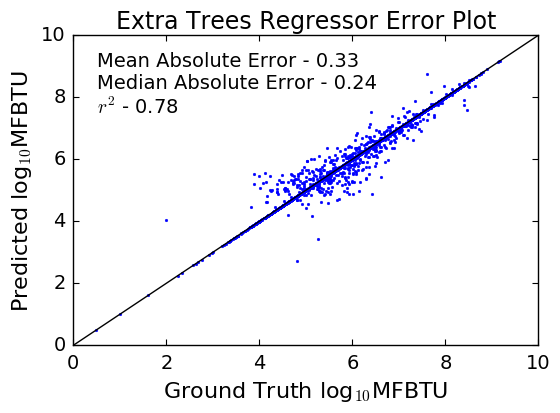

Min error: 0.000000
Max error: 2.089192


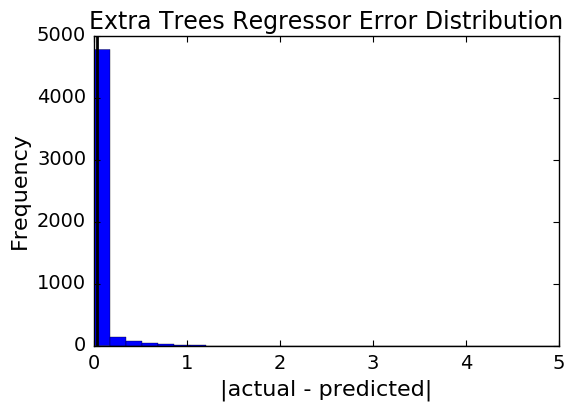

MLP Regressor
Training model 12/13	MLP Regressor


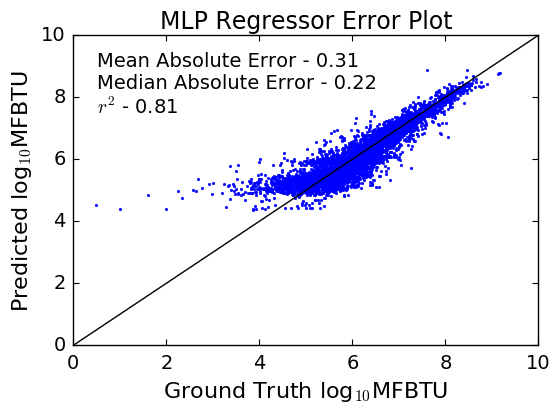

Min error: 0.000063
Max error: 4.050973


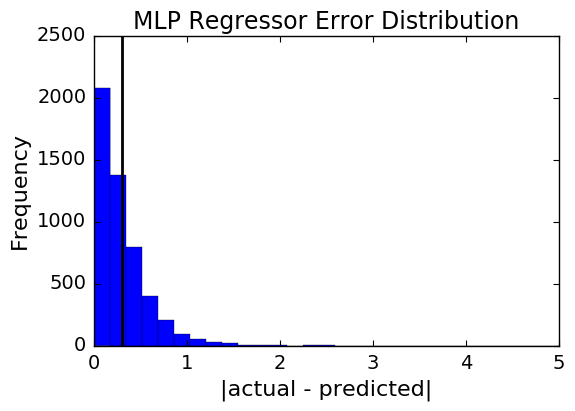

KNN Regressor
Training model 13/13	KNN Regressor


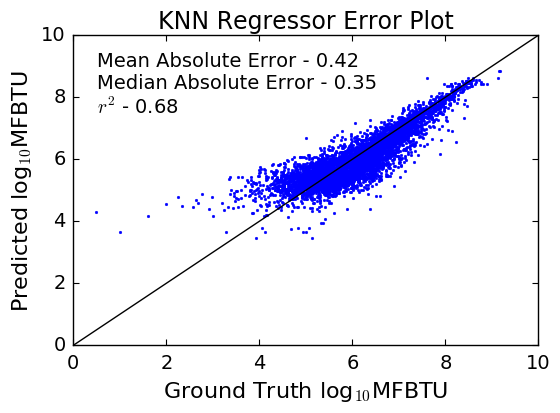

Min error: 0.000045
Max error: 3.809455


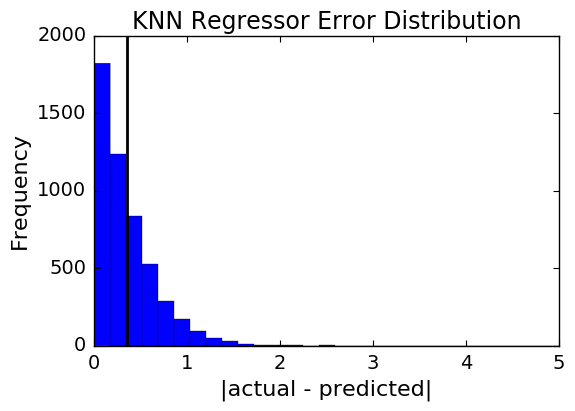

In [10]:
X,Y,columnNames,classVals = getDataset(DATASET,pbaOneHot=True)
classOrdering,classFrequencies = getClassFrequencies(classVals)
numClassVals = len(classFrequencies)
Y = np.log10(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_all_scaled = scaler.transform(X)

for i in range(numRegressors):
    regressor = sklearn.base.clone(regressors[i])
    regressorName = regressorNames[i]
    
    print regressorName
    #if regressorName != "XGBoost" and regressorName!= "Linear Regression":
    #    continue
    
    print "Training model %d/%d\t%s" % (i+1, len(regressors), regressorName)

    
    regressor.fit(X_train_scaled,Y_train)
    
    #predict model
    predicted = regressor.predict(X_test_scaled)
    predicted[predicted<0] = 0

    #evaluate model
    scores = []
    for l,metric in enumerate(metrics):
        metricName = metricNames[l]
        score = metric(Y_test,predicted)
        scores.append((metricName,score))
    
    predicted = regressor.predict(X_all_scaled)
    
    #----------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------
    
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    
    ax.scatter(Y, predicted, color='b', s=4, label="Predicted")
    
    ax.plot([0,10],[0,10], color='k', linewidth=1)
    
    displayString = []
    for metricName, score in scores:
        displayString.append("%s - %0.2f" % (metricName, score))
    displayString = '\n'.join(displayString)
    ax.text(0.5, 7.5, displayString, fontsize=14)

    #ax.set_xscale('symlog')
    #ax.set_yscale('symlog')

    ax.set_xlim([0,10])
    ax.set_ylim([0,10])
    
    ax.set_title("%s Error Plot" % (regressorName), fontsize=17)
    ax.set_xlabel("Ground Truth log$_{10}$MFBTU", fontsize=16)
    ax.set_ylabel("Predicted log$_{10}$MFBTU", fontsize=16)

    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.savefig(os.path.join(RESULTS_DIR, "errorPlots/%s_errorPlot.png"  % (regressorName.replace(' ','_'))), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    #----------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------
    
    absoluteErrors = np.abs(Y - predicted)
    
    print "Min error: %f" % (absoluteErrors.min())
    print "Max error: %f" % (absoluteErrors.max())
    
    fig, ax = plt.subplots(1,1,figsize=(6,4))
        
    ax.set_title("%s Error Distribution" % (regressorName), fontsize=17)
    ax.set_xlabel("|actual - predicted|", fontsize=16)
    ax.set_ylabel("Frequency", fontsize=16)
        
    ax.hist(absoluteErrors, bins=np.linspace(0,5,30))
    ax.axvline(x=absoluteErrors.mean(), linewidth=2, color='k')
    
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xlim([0,5])
    
    plt.savefig(os.path.join(RESULTS_DIR, "errorPlots/%s_errorDist.png"  % (regressorName.replace(' ','_'))), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    